<h1><center>Sentiment Analysis Classifier with BERT</center></h1>

This project is based on Manning's book "Transfer Learning for NLP" (chapter 2).
The goal here is:

1. Curate a dataset with reviews from imdb classic dataset
2. Create a Pandas dataframe from it.
3. Create a simple bag-of-words model from the above content. Simple because it is based on term frequency (tf) only.
4. Choose one baseline classifier from Logistic Regression and Gradient Boosting Machine
5. Accuracy will be the metric of choice as the dataset is balanced and consists of two classes
6. Train a SentimentAnalysis classifier based on BERT embeddings

But before starting let's make sure we have the correct libraries versions installed, namelly tensorflow and bert-tensorflow.

In [1]:
import sys
!{sys.executable} -m pip install -r requirements-colab.txt

     |████████████████████████████████| 411.0MB 41kB/s 
     |████████████████████████████████| 112kB 59.3MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
     |████████████████████████████████| 378kB 57.6MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 3.8MB 50.5MB/s 
     |████████████████████████████████| 512kB 63.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3617f9da2de77db20578201b21f97db705dccf515d436a93bcc2283622716190
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorflow-estimator

Now we will import required Python libraries and the dataset. To download the dataset I will use the bash script get_aclImdb.sh. It downloads and extracts the compressed archive into ./data/aclImdb. It requires execution privilege (sudo chmod +x get_aclImdb.sh).

In [2]:
import pandas as pd 
import numpy as np 
import pickle as pck 
import os.path
from os import path

# download dataset
!sudo chmod +x get_aclImdb.sh
!./get_aclImdb.sh

./model/bert/assets created!.
--2020-12-29 22:05:17--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  23.8MB/s    in 3.4s    

2020-12-29 22:05:20 (23.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

aclImdb downloaded and extracted into ./data/.
--2020-12-29 22:05:26--  https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1?tf-hub-format=compressed
Resolving tfhub.dev (tfhub.dev)... 172.217.164.142, 2607:f8b0:4004:814::200e
Connecting to tfhub.dev (tfhub.dev)|172.217.164.142|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/tfhub-modules/google/bert_uncased_L-12_H-768_A-12/1.tar.gz [follow

# Hyperparameters

In [3]:
max_tokens = 256 # maximum number of tokens per review
max_chars = 20 # maximum size of a token.
n_samples = 25000 # number of training instances

Three helper methods to tokenize, remove stopwords, remove puntuation and convert to lowercase

In [4]:
def load_dataset_tfidf(path):

    # Reviews will be loaded in sequence, i.e., first all negative s followed by all positives.
    reviews, sentiments = [], []
    for folder, sentiment in (('neg', 0), ('pos', 1)):
        folder = os.path.join(path, folder)
        for name in os.listdir(folder):
            with open(os.path.join(folder, name), 'r') as reader:
                text = reader.read()

            reviews.append(text)
            sentiments.append(sentiment)

    return reviews, sentiments

In [5]:
# Loaded dataset comes tokenized, lowercased and without both stopwords and punctuations

train_path = os.path.join('data/aclImdb', 'train')
reviews_train, sentiments_train = load_dataset_tfidf(train_path)
print(f'Number of training reviews: {len(reviews_train)} and labels: {len(sentiments_train)}')

test_path = os.path.join('data/aclImdb', 'test')
reviews_test, sentiments_test = load_dataset_tfidf(test_path)
print(f'Number of testing reviews: {len(reviews_test)} and labels: {len(sentiments_test)}')

Number of training reviews: 25000 and labels: 25000
Number of testing reviews: 25000 and labels: 25000


As seen previously this dataset may be huge to be digested in some environments. So let's limit the train dataset to the hyperparameter n_samples. The idea is to have a dataset with evenly distributed samples from negative and positive labels.

# BOW for Logistic Regression

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(reviews_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [7]:
import random

def shuffle_data(data, label):

    data_tmp = np.array(data)
    label_tmp = np.asarray(label)
    index_shuffle = np.random.permutation(data_tmp.shape[0])
    data_tmp = data_tmp[index_shuffle]
    label_tmp = label_tmp[index_shuffle]

    return data_tmp.tolist(), label_tmp.tolist()

In [8]:
def shuffle_and_sample_data(data, label, n_samples=1000):

    data_tmp = np.array(data)
    label_tmp = np.asarray(label)
    index_shuffle = np.random.permutation(n_samples)
    data_tmp = data_tmp[index_shuffle]
    label_tmp = label_tmp[index_shuffle]

    return data_tmp.tolist(), label_tmp.tolist()

In [9]:
print(len(sentiments_train))
reviews_train, sentiments_train = shuffle_data(reviews_train, sentiments_train)


25000


In [10]:
train_x = vectorizer.transform(reviews_train)
train_y = np.array(sentiments_train)

# Logistic Regression 

In [11]:
from sklearn.linear_model import LogisticRegression

def fit(train_x, train_y):

    model = LogisticRegression()

    try:
        model.fit(train_x, train_y)
    except:
        pass

    return model

In [12]:
print(train_x.shape, train_y.shape)
model = fit(train_x, train_y)

(25000, 74849) (25000,)


In [13]:
test_x = vectorizer.transform(reviews_test)
test_y = np.array(sentiments_test)

In [14]:
predictions = model.predict(test_x)

In [15]:
from sklearn.metrics import accuracy_score

accuracy_score = accuracy_score(test_y, predictions)
print(f'LogisticRegression accucary is: {accuracy_score: .4f}')

LogisticRegression accucary is:  0.8832


In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

# Making sure we have the correct tensorflow version
assert tf.__version__ == "1.15.2", 'Correct tensorflow version is 1.15.2'

Using TensorFlow backend.


In [17]:
# starting TF sessions and setting it to keras backend
sess = tf.Session()
K.set_session(sess)

In [18]:
sess = tf.Session()

class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self,
        n_fine_tune_layer = 10,
        pooling = 'mean',
        bert_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1',
        **kwargs
    ):

        self.n_fine_tune_layer = n_fine_tune_layer
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path

        super(BertEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_features):

        self.bert_layer = hub.Module(
            self.bert_path, trainable=self.trainable, name=f'{self.name}_module')

        print(type(self.bert_layer))

        trainable_vars = self.bert_layer.variables
        
        if self.pooling == 'first':
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]
        elif self.pooling == 'mean':
            trainable_vars = [
                var for var in trainable_vars
                if not "/cls/" in var.name 
                and not "/pooler/" in var.name]

            trainable_layers = []
        else:
            raise NameError('Undefined pooling type')

        for i in range(self.n_fine_tune_layer):
            trainable_layers.append(f'encoder/layer_{str(11 - i)}')

        trainable_vars = [
            var for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert_layer.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertEmbeddingLayer, self).build(input_features)

    def call(self, inputs):
        inputs = [K.cast(x, dtype='int32') for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)

        if self.pooling == 'first':
            pooled = self.bert_layer(
                inputs=bert_inputs, signature='tokens', as_dict=True)['pooled_output']

        elif self.pooling == 'mean':
            result = self.bert_layer(
                inputs=bert_inputs, signature='tokens', as_dict=True)['sequence_output']

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (tf.reduce_sum(m, axis=1, keep_dims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)

        else:
            raise NameError('Undefined pooling type')

        return pooled

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_fine_tune_layer': self.n_fine_tune_layer,
            'pooling': self.pooling,
            'bert_path': self.bert_path,
        })
        return config

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [19]:
def convert_data_to_bert_feature_format(x, y):

    # Converted_data to np.array
    converted_data = np.array(x, dtype=object)[:, np.newaxis]

    return converted_data, np.array(y)


reviews_train, sentiments_train = shuffle_and_sample_data(reviews_train, sentiments_train, n_samples)
reviews_test, sentiments_test = shuffle_and_sample_data(reviews_test, sentiments_test, n_samples)

data_train, labels_train = convert_data_to_bert_feature_format(reviews_train, sentiments_train)
data_test, labels_test = convert_data_to_bert_feature_format(reviews_test, sentiments_test)

print(labels_train.shape)
print(labels_test.shape)
print(data_train.shape)
print(data_test.shape)

(25000,)
(25000,)
(25000, 1)
(25000, 1)


In [20]:
def build_model(max_seq_length):

    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name='input_ids')
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name='input_masks')
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name='segment_ids')
    bert_layer_inputs = [in_id, in_mask, in_segment]

    bert_output = BertEmbeddingLayer(n_fine_tune_layer=0)(bert_layer_inputs)
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=bert_layer_inputs, outputs=output)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [21]:
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [22]:
from tqdm import tqdm
import kerasBert as kb
import bert.tokenization as tk
from tensorflow_hub import Module
import pkg_resources as pkg
import bert_utils as bu

# Making sure we have install the correct libraries.
assert pkg.get_distribution("bert-tensorflow").version == '1.0.1', 'Change bert-tensorflow version to 1.0.1'

vocab_file_path = './model/bert/assets/vocab.txt'
tokenizer = bu.create_tokenizer(vocab_file_path)

train_examples = kb.convert_text_to_examples(data_train, labels_train)
test_examples = kb.convert_text_to_examples(data_test, labels_test)

(train_input_ids, train_input_masks, train_segment_ids, train_labels) = kb.convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_tokens)

(test_input_ids, test_input_masks, test_segment_ids, test_labels) = kb.convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_tokens)

Converting examples to features: 100%|██████████| 25000/25000 [01:12<00:00, 343.67it/s]


In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('model/bert/bert_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Num GPUs Available:  1
Build and training model!
<class 'tensorflow_hub.module.Module'>
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_embedding_layer (BertEmbed (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]            

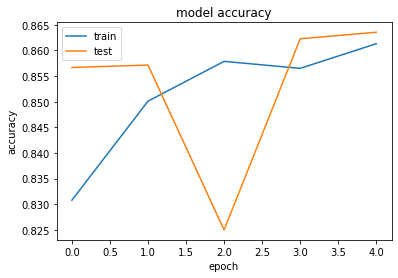

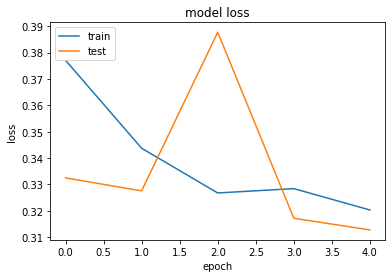

--------------------------------
Applying classifier on examples:
--------------------------------
The movie was excellent: is POSITIVE!
The movie was horrible: is NEGATIVE!
Oh! What a magnificent movie.: is POSITIVE!


In [25]:
import os
import matplotlib.pyplot as plt
import pickle

# Will train only if bert_model.h5 does not exist
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if not os.path.exists('model/bert/bert_model.hdf5'):
    print('Build and training model!')
    model = build_model(max_tokens)

    # Initialize keras.backend==tensorflow session
    initialize_vars(sess)

    # Fitting the model
    history = model.fit([train_input_ids, train_input_masks, train_segment_ids], train_labels, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels), epochs=5, batch_size=32)

    # Saving history dictionary
    history_dict = history.history
    tf.keras.models.save_model(model, 'model/bert/bert_model.hdf5')
    with open('model/bert/train_history_dict', 'wb') as file_pi:
        pickle.dump(history_dict, file_pi)
else:
    print('Loading trained model!')
    model = tf.keras.models.load_model('model/bert/bert_model.hdf5', {'BertEmbeddingLayer': BertEmbeddingLayer})
    with open("model/bert/train_history_dict", "rb") as fp:
        history_dict = pickle.load(fp)

# ploting history for accuracy and loss
plt.plot(history_dict['acc'])
plt.plot(history_dict['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ploting history for loss
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Now lets see examples working
print('--------------------------------')
print('Applying classifier on examples:')
print('--------------------------------')

text_examples = ['The movie was excellent', 'The movie was horrible', 'Oh! What a magnificent movie.']

# Here I am classifying messages one at a time just to work with different helper functions.
# This could be dealt as we did with training however,i.e., using kb.convert_text_to_examples
# and then kb.convert_examples_to_features.

for text_example in text_examples:
    # example should be an instance of class InputExample in keras-bert.py
    example = kb.InputExample(None, text_example)

    # helpser methos from keras-bert.py
    (example_input_id, example_input_mask, example_segment_id, example_label) = kb.convert_single_example(tokenizer, example, max_seq_length=max_tokens)

    # predicting
    predict = model.predict([np.reshape(example_input_id, (1, len(example_input_id))), np.reshape(example_input_mask, (1, len(example_input_mask))), np.reshape(example_segment_id, (1, len(example_segment_id)))])
    if predict[0] < 0.5:
        print(f'{example.text_a}: is NEGATIVE!')
    else:
        print(f'{example.text_a}: is POSITIVE!')